In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os

In [2]:
cell_type_map_exp = {'Astro' : 'Astro',
 'Endo': 'Endo',
 'L2-3_IT': 'L2/3 IT',
 'L2/3 IT': 'L2/3 IT',
 'L2.3_IT':'L2/3 IT',
 'L4_IT': 'L4 IT',
 'L5-6_NP': 'L5/6 NP',
 'L5.6_NP':'L5/6 NP',
 'L5_ET': 'L5 ET',
 'L5_IT': 'L5 IT',
 'L6_CT' : 'L6 CT',
 'L6_IT': 'L6 IT',
 'L6_IT_Car3': 'L6 IT Car3',
 'L6b' : 'L6b',
 'Lamp5': 'Lamp5',
 'Lamp5_Lhx6': 'Lamp5_Lhx6',
 'Lamp_Lhx6': 'Lamp5_Lhx6',
 'Micro_PVM': 'Micro-PVM',
 'OPC': 'OPC',
 'Oligo': 'Oligo',
 'Pax6': 'Pax6',
 'Pvalb': 'Pvalb',
 'Pvalb_ChC': 'Chandelier',
 'Sncg': 'Sncg',
 'Sst': 'Sst',
 'Sst_Chodl': 'Sst Chodl',
 'VLMC': 'VLMC',
 'Vip': 'Vip',
'None': 'None'}

In [3]:
file_1 = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/fluorescence_scoring_sheet.tsv'
file_2 = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/SSv4_scoring_sheet.tsv'

species='mouse'

df_target = pd.read_csv(file_1, sep='\t')

#used the mapped coordinates from human to mouse
df_target['Coordinates_Enhancer_human'] = [x if y == 'Mouse' else z for x,y,z in zip(df_target['Coordinates Enhancer (Species)'].tolist(), df_target['Species'].tolist(), df_target['Liftover_coordinates (Alt-Species)'].tolist() )]

df_target = df_target.dropna(subset=['Coordinates_Enhancer_human'], axis=0)

In [4]:
#write bed file for enhancer coordinates
df_target['chrom'] = [x.split(':')[0] for x in df_target['Coordinates_Enhancer_human'].tolist()]

df_target['st'] = [x.split('-')[0].split(':')[1] for x in df_target['Coordinates_Enhancer_human'].tolist()] 

df_target['end'] = [x.split('-')[1] for x in df_target['Coordinates_Enhancer_human'].tolist()] 

df_target[['chrom', 'st', 'end', 'Enhancer_ID']].to_csv(f'/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed', index=False, header=False, sep='\t')


In [5]:
df_target

Enhancer_ID Coordinates Enhancer (Species)  \
0      AiE0007m          chr10:5735065-5735577   
1      AiE0019h       chr5:135632529-135633094   
2      AiE0019m        chr13:56336845-56337409   
3      AiE0025h         chr5:75926213-75926665   
4      AiE0025m        chr13:96264520-96264922   
..          ...                            ...   
672    AiE0586m         chr2:66463673-66464195   
673    AiE0587m         chr2:66784672-66785167   
674    AiE0585m         chr2:66367991-66368319   
675    AiE0588h       chr2:167553590-167553974   
676    AiE0591m         chr2:81374976-81375404   

                          Enhancer_sequence Enhancer 1  Length Species  \
0    CTGGTAGAGTGGCAGAGAGAGAGAGAGAAAAGGAAACGCTAGAAAA...     508   Mouse   
1    TCCATCCACAGTCTGTCATCTTCCCCTTGTACAGATTGGCTGCCCT...     576   Human   
2    TTCTCCATCCATGTCCTCCTGACTTCCCTCTGCTCTGTCAACTCCC...     592   Mouse   
3    CCCAAACTCTCATCTGCTCCAAGCTGTATAGAAGTTTCTTTCAGAG...     475   Human   
4    TGCTCCAACATTTGCAGTCATATAATAGATGTTTCTTTTAGAGTTA...     440   Mouse   
..                                                 ...     ...     ...   
672  AGCATAGCCAGGGCATAACACTCCTATGGTGACCCCAGACACCCAG...     601   Mouse   
673  TTGCTGTCAAATGCTAGTCTTCACTAAAACTCCAGCAAGAACCCCA...     521   Mouse   
674  TACTGGTTAGCTTTCAATCTGACAGTTAAAGTCAGTCAACCAGTGT...     366   Mouse   
675  CCATATAGGGGCTTAGATCTTTTTTAGACCTAAATTGCTGTGTTTT...     386   Human   
676  TCTCTTAGACTAGTAAGCAGAATATAGACAGATATCTCTTAAAATA...     495   Mouse   

    max_subclass_primary max_subclass_Secondary    Correlation Liftover  \
0                    Vip                    NaN      Conserved      Yes   
1                  Lamp5                    NaN      Conserved      Yes   
2                   Pax6                   Sncg      Conserved      Yes   
3             Lamp5_Lhx6                  Lamp5      Conserved      Yes   
4                  Lamp5                    NaN      Conserved      Yes   
..                   ...                    ...            ...      ...   
672                  Vip                    NaN    No_Liftover       No   
673                  Vip                   Sncg  Not_Conserved      Yes   
674           Lamp5_Lhx6              Pvalb_ChC  Not_Conserved      Yes   
675                Pvalb                    NaN      Conserved      Yes   
676            Pvalb_ChC                    Vip  Not_Conserved      Yes   

    Liftover_coordinates (Alt-Species)  \
0             chr6:152893083-152893625   
1              chr13:56336894-56337459   
2             chr5:135632580-135633144   
3              chr13:96264569-96264972   
4               chr5:75926275-75926714   
..                                 ...   
672                                NaN   
673           chr2:166493981-166494575   
674           chr2:166086747-166087834   
675             chr2:67805924-67806299   
676           chr2:183911986-183912131   

                                             gene_dist  \
0        70279|88589|96104|141547|184629|187079|666127   
1    21123.5|53820.5|180460.5|201836.5|263029.5|322...   
2    25772|40576|84964|89466|93187|101227|145119|15...   
3    156943|213984|315258|414301|414595|589260|6826...   
4    123572|131353|132144|171265|182564|183345|2260...   
..                                                 ...   
672                                                NaN   
673                                                NaN   
674                                                NaN   
675                 260782|366500|412827|693813|902466   
676                                                NaN   

                                       new_correlation  \
0                                0|0|0.97|0|0.1|0.02|0   
1    0|0.85|0|0.8|0|0|0|0.54|0|-0.13|0|0|0|0|0|-0.0...   
2    0|0.85|0|0|0|0|0|0|0|0.36|0|0|0|0|0|0|0|0|0|0|...   
3     0.78|0.11|-0.1|0.25|0.07|0.2|0|-0.1|0|0|-0.2|0|0   
4    0.4|0|0.93|0|0|0|0|-0.08|0.13|0|-0.03|-0.08|0|...   
..                                                 ...   
672  

In [5]:

#build class X enhancer matrix where On-Target or Mixed-Target are marked as 1 and remaing as 0
d1 = df_target.copy()
d1['p_s_cell_type']= df_target['max_subclass_primary'].tolist()
d2 = df_target.copy()
d2['p_s_cell_type']= df_target['max_subclass_Secondary'].tolist()
df_target = pd.concat([d1,d2])

df_target = df_target.dropna(subset=['p_s_cell_type'] , axis=0)

df_target['p_s_cell_type'] = [cell_type_map_exp[x] for x in df_target['p_s_cell_type'].tolist()]

df_target['pos_neg'] = [1 if (x =='On-Target') else 1 if x =='Mixed-Target' else 0 if x =='Off-Target' else 0 for x in df_target['LABEL_Specificity']]

df_target  =  df_target[(df_target['LABEL_Specificity']=='On-Target') | (df_target['LABEL_Specificity']=='Mixed-Target')].pivot_table(columns='Enhancer_ID', index=['p_s_cell_type'], values='pos_neg', aggfunc='sum')

df_target = df_target.fillna(0)

df_target[df_target>1] = 1





In [6]:
#build class X enhancer matrix where above 5 is considered as true (1) and remaing as false (0)

df_target2 = pd.read_csv(file_2, sep='\t')



df_target2.columns = [cell_type_map_exp[x] if x in cell_type_map_exp.keys() else x for x in df_target2.columns.tolist()]

df_target2 = df_target2[['L2/3 IT', 'L4 IT', 'L5 IT',
       'L6 IT', 'L6 IT Car3', 'L5 ET', 'L5/6 NP', 'L6 CT', 'L6b', 'Lamp5',
       'Lamp5_Lhx6', 'Pax6', 'Sncg', 'Vip', 'Sst Chodl', 'Sst', 'Pvalb',
       'Chandelier', 'Astro', 'OPC', 'Oligo', 'VLMC', 'Endo', 'Micro-PVM', 'Enhancer_ID']]

df_target2  =  df_target2.set_index('Enhancer_ID').T
df_target2[df_target2>=5] = 1
df_target2[df_target2<5] = 0




In [7]:
#merged the two files to get all true positives and negative for each enhancer for each subclass
df_exp_all = pd.concat([df_target,df_target2], axis=1).fillna(0)

df_exp_all = df_exp_all.groupby(df_exp_all.columns, axis=1).sum()
df_exp_all[df_exp_all >1] = 1


In [ ]:
#cell_type_map = {'VLMC' : 'VLMC' ,
#'Micro-PVM' : 'MGC' ,
#'Astro' : 'ASC' ,
#'L2/3 IT' : 'L2_3_IT' ,
#'L5 IT' : 'L5_IT' ,
#'Oligo' : 'ODC' ,
#'Sst' : 'SST' ,
#'Pvalb' : 'PVALB' ,
#'Vip' : 'VIP' ,
#'Endo' : 'Endo' ,
#'Lamp5' : 'LAMP5' ,
#'Sncg' : 'SNCG' ,
#'L5/6 NP' : 'L5_6_NP' ,
#'L5 ET' : 'L5_ET' ,
#'L6 CT' : 'L6_CT' ,
#'L6b' :  'L6b' ,
#'Sst Chodl' : 'SST' ,
#'L6 IT' : 'L6_IT' 
#}#

#species='mouse'#

#df_marker = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')#

#df_marker = df_marker.drop_duplicates('group')#

#class_dict = dict(zip(df_marker.group, df_marker.classt))#

#df_atac_subclass_macs2 = pd.read_csv(f'/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/Supplementary_Table_7.tsv', sep='\t')#
#
#

#df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['coord']]
#df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['coord']]
#df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['coord']]
#df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
#df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
#df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
#df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])#
#
#

#df_list = []
#for keyl in cell_type_map.keys():#

#    df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
#    df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
#    df['cell_type'] = keyl
#    df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
#df_Zemke2023_label = pd.concat(df_list)#

#df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()
#b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/'#

#df_Zemke2023_label.to_csv(f'{b_dir}/df_Zemke2023_label.bed', index=False, header=False, sep='\t')


In [8]:

b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/'

os.system(f"bedtools intersect -wo -b {b_dir}/df_Zemke2023_label.bed -a /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed > {b_dir}/all_cre_bins.bed")



df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'enhancer_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

df_Zemke2023['rank'] = 1





df_Zemke2023 = df_Zemke2023.sort_values(by=['overlap'], ascending=False).drop_duplicates(subset=['cell_type', 'enhancer_id'])
df_Zemke2023_table = df_Zemke2023.pivot_table(index='enhancer_id', columns='cell_type', values='rank', aggfunc='sum')

df_Zemke2023_table.fillna(0, inplace=True)

df_Zemke2023_table[df_Zemke2023_table != 0] = 1

df_Zemke2023_table = df_Zemke2023_table.T



In [ ]:
#species='mouse'
#df_Zu2023 = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/subclass_manual.tsv', sep='\t')#

#df_Zu2023 = df_Zu2023.dropna(subset=['Metamarkers'])#

#b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/cre_subclass/catlas.org/renlab_downloads/wholemousebrain/sa2.subclassv3.final.peak.srt'#
#
#

#df_list = []
#for marker_label, name_label in zip(df_Zu2023['Metamarkers'].tolist()[:-1], df_Zu2023['subclass_label_peak'].tolist()[:-1]):
#    df =  pd.read_csv(f'{b_dir}/{name_label}.bed', sep='\t', names=['chr', 'st', 'end', 'label'])
#    df['cell_type'] =  marker_label
#    df_list.append(df)
#df_Zu2023_label = pd.concat(df_list)
#                                    
#                                    #

#df_Zu2023_label = df_Zu2023_label.drop_duplicates()#

#b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/cre_subclass/catlas.org/renlab_downloads/wholemousebrain/'#
#

#df_Zu2023_label.to_csv(f'{b_dir}/df_Zu2023_label.bed', index=False, header=False, sep='\t')





In [9]:
b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/cre_subclass/catlas.org/renlab_downloads/wholemousebrain/'


os.system(f"bedtools intersect -wo -b {b_dir}/df_Zu2023_label.bed -a /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed > {b_dir}/all_cre_bins.bed")




df_Zu2023 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'enhancer_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

df_Zu2023['rank'] = 1


df_Zu2023 = df_Zu2023.sort_values(by=['overlap'], ascending=False).drop_duplicates(subset=['cell_type', 'enhancer_id'])

df_Zu2023_table = df_Zu2023.pivot_table(index='enhancer_id', columns='cell_type', values='rank', aggfunc='sum').T

df_Zu2023_table.fillna(0, inplace=True)

df_Zu2023_table[df_Zu2023_table != 0] = 1


In [ ]:
#df_Li2021 = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/SupplementaryTable3Cellclusterannotation_manual.tsv', sep='\t')#

#df_Li2021 = df_Li2021.dropna(subset=['Metamarker'])#

#b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/cell-type-cre/catlas.org/catlas_downloads/mousebrain/cCREs'#

#df_list = []
#for marker_label, name_label in zip(df_Li2021['Metamarker'].tolist(), df_Li2021['Sub types'].tolist()):
#    df =  pd.read_csv(f'{b_dir}/{name_label}.cCRE.bed', sep='\t', names=['chr', 'st', 'end', 'label'])
#    df['cell_type'] =  marker_label
#    df_list.append(df)
#df_Li2021_label = pd.concat(df_list)#

#df_Li2021_label = df_Li2021_label.drop_duplicates()#

#df_Li2021_label.to_csv(f'{b_dir}/df_Li2021_label.bed', index=False, header=False, sep='\t')


In [10]:



b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/cell-type-cre/catlas.org/catlas_downloads/mousebrain/cCREs'

#os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")
#os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed > {b_dir}/all_cre_bins.bed")
os.system(f"bedtools intersect -wo -b {b_dir}/df_Li2021_label.bed -a /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed > {b_dir}/all_cre_bins.bed")



df_Li2021 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'enhancer_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])


df_Li2021['diff'] = [x-y if x>y else y-x for x,y in zip(df_Li2021['p_end'], df_Li2021['p_st'])]

df_Li2021['rank'] = 1

#df_Li2021 = df_Li2021[df_Li2021['overlap'] > 250]


df_Li2021['cell_type'] = [x if x!= 'Lamp5 ' else 'Lamp5' for x in df_Li2021['cell_type']]

df_Li2021  = df_Li2021.sort_values(by=['overlap'], ascending=False).drop_duplicates(subset=['cell_type', 'enhancer_id'])

df_Li2021_table = df_Li2021.pivot_table(index='enhancer_id', columns='cell_type', values='rank', aggfunc='sum').T

df_Li2021_table.fillna(0, inplace=True)

df_Li2021_table[df_Li2021_table != 0] = 1


In [11]:
#combine the 3 different ATAC CREs to create meta CRE file

df_meta = pd.concat([df_Zu2023_table, df_Li2021_table, df_Zemke2023_table])


df_meta = df_meta.fillna(0)

df_meta = df_meta.groupby(df_meta.index).mean().reset_index()



df_meta = df_meta.set_index('cell_type')



In [12]:
import os
import pandas as pd

# Input and output file paths
file_enhancer_specificity = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/mouse_peak_metrics-2/mouse_specificity_proportion-Table 1.tsv'
output_bed = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer_specificity.bed'
output_intersect_bed = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer_specificity_intersect.bed'
bins_enhancer_bed = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed'

# Read the initial data file
df_enhancer_specificity = pd.read_csv(file_enhancer_specificity, sep='\t')

# Create BED file from the dataframe
df_enhancer_specificity[['chr', 'start', 'end', 'id']].to_csv(output_bed, index=False, header=False, sep='\t')

# Run bedtools intersect to find overlapping regions
bedtools_cmd = f"bedtools intersect -wo -b {output_bed} -a {bins_enhancer_bed} > {output_intersect_bed}"
os.system(bedtools_cmd)

# Read the resulting bedtools intersect output
enhancer_bins_specificity = pd.read_csv(output_intersect_bed, sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'id', 'overlap'])

# Sort by overlap and drop duplicates
enhancer_bins_specificity = enhancer_bins_specificity.sort_values(by=['overlap'], ascending=False).drop_duplicates(subset=['bin_id'])

# Merge with the original dataframe and drop unnecessary columns
df_enhancer_specificity = enhancer_bins_specificity.merge(df_enhancer_specificity).drop(columns=['d', 'd1', 'd2', 'c', 'c1', 'c2', 'id', 'overlap', 'chr', 'start', 'end'])

# Set bin_id as the index and transpose the dataframe
df_enhancer_specificity = df_enhancer_specificity.set_index('bin_id').T

# Update the index to remove the prefix from column names
df_enhancer_specificity.index = [x.split('specificity_proporiton_')[1] for x in df_enhancer_specificity.index.tolist()]

# Copy the processed dataframe
exp_atac = df_enhancer_specificity.copy()


In [ ]:
#df_list = []#

## Path templates
#input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_gene_intra_KR_0_z_scores_False_False_brain_class_{markers}_by_allbins_max_mean.h5ad'
## Read data from h5ad files for different marker counts
#for no_of_markers in [200, 100, 300, 400, 500]:
#    outputfile_h5ad = input_path_template.format(markers=no_of_markers)#

#    # Read AnnData file
#    adata = ad.read_h5ad(outputfile_h5ad, backed='r')#

#    # Convert to DataFrame
#    df = adata.to_df(layer='mean')
#    df_list.append(df)#

## Concatenate all DataFrames and group by index, taking the mean
#df = pd.concat(df_list)
#df = df.groupby(df.index).mean()#
#

#adata = ad.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))#

## Write AnnData object to a file
#output_file = 'path_to_output_file.h5ad'
#adata.write('/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_cell_type_mean_per_bin.h5ad')


In [35]:
df_list = []

## Path templates
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/brain_class/mean/hic_gene_KR_intra_0_z_scores_True_False_brain_class_{markers}_by_allbins_max_mean.h5ad'
## Read data from h5ad files for different marker counts
for no_of_markers in [200]:
    outputfile_h5ad = input_path_template.format(markers=no_of_markers)#

#    # Read AnnData file
    adata = ad.read_h5ad(outputfile_h5ad, backed='r')#

#    # Convert to DataFrame
    df = adata.to_df(layer='mean')
    df_list.append(df)

## Concatenate all DataFrames and group by index, taking the mean
df = pd.concat(df_list)
df = df.groupby(df.index).mean()#
#

adata = ad.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))#

## Write AnnData object to a file
output_file = 'path_to_output_file.h5ad'
adata.write('/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_cell_type_mean_per_bin_c.h5ad')


In [36]:
df_list = []

## Path templates
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/brain_class/mean/hic_gene_none_inter_0_z_scores_False_False_brain_class_{markers}_by_allbins_max_mean.h5ad'
## Read data from h5ad files for different marker counts
for no_of_markers in [200]:
    outputfile_h5ad = input_path_template.format(markers=no_of_markers)#

#    # Read AnnData file
    adata = ad.read_h5ad(outputfile_h5ad, backed='r')#

#    # Convert to DataFrame
    df = adata.to_df(layer='mean')
    df_list.append(df)

## Concatenate all DataFrames and group by index, taking the mean
df = pd.concat(df_list)
df = df.groupby(df.index).mean()#
#

adata = ad.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))#

## Write AnnData object to a file
output_file = 'path_to_output_file.h5ad'
adata.write('/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_cell_type_mean_per_bin_t.h5ad')


In [ ]:
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_gene_intra_KR_0_z_scores_False_False_brain_class_{markers}_by_allbins_max_mean.h5ad'



In [ ]:
k

In [14]:
import os
import anndata as ad
import pandas as pd

In [14]:
import os
import anndata as ad
import pandas as pd



# Path templates
input_path_hic = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_cell_type_mean_per_bin.h5ad'


output_bed_intersect = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/challenge_bins.bed'
regions_bed_file = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/regions_bed_file.tsv'
enhancer_bed_file = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed'


adata = ad.read_h5ad(input_path_hic, backed='r')

In [17]:
j = adata.to_df()

In [19]:
j.min().min()

0.0

In [15]:
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/100kbp_raw/max/hic_gene_intra_KR_0_z_scores_False_False_brain_class_1_by_allbins_max_mean.h5ad'

adata = ad.read_h5ad(input_path_template, backed='r')


In [20]:
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/100kbp_raw/max/brain_class/mean/hic_gene_KR_intra_0_z_scores_False_False_brain_class_1_by_allbins_max_mean.h5ad'

adata = ad.read_h5ad(input_path_template, backed='r')


In [67]:
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/100kbp_raw/max/brain_class/mean/hic_gene_KR_intra_0_z_scores_False_True_brain_class_1_by_allbins_max_mean.h5ad'
adata = ad.read_h5ad(input_path_template, backed='r')


In [71]:
input_path_template = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_human/aggregates/250kbp_raw/max/hic_gene_intra_KR_by_allbins_max.h5ad'

adata = ad.read_h5ad(input_path_template, backed='r')

In [21]:
adata

AnnData object with n_obs × n_vars = 23 × 24639 backed at '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/100kbp_raw/max/brain_class/mean/hic_gene_KR_intra_0_z_scores_False_False_brain_class_1_by_allbins_max_mean.h5ad'
    layers: 'counts', 'mean'

In [22]:
df = adata.to_df(layer='mean')

In [23]:
df.min().min()

-0.4269577728982487

In [69]:
df.min().min()

-0.4269577728982487

In [53]:
import os
import anndata as ad
import pandas as pd



# Path templates
input_path_hic = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_cell_type_mean_per_bin_t.h5ad'


output_bed_intersect = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/challenge_bins.bed'
regions_bed_file = '/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/regions_bed_file.tsv'
enhancer_bed_file = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/bins_enhancer.bed'


adata = ad.read_h5ad(input_path_hic, backed='r')

# Convert to DataFrame
df = adata.to_df()

# Run bedtools intersect command
bedtools_cmd = f"bedtools intersect -wo -b {regions_bed_file} -a {enhancer_bed_file} > {output_bed_intersect}"
os.system(bedtools_cmd)

# Read the resulting bed file
df_bin_id = pd.read_csv(output_bed_intersect, sep='\t', names=['chr', 'st', 'end', 'enhancer_id', 'chrs', 'stt', 'endd', 'bin_id', 'overlap'])

# Sort by overlap and drop duplicates
df_bin_id = df_bin_id.sort_values(by=['overlap'], ascending=False).drop_duplicates(subset=['enhancer_id'])

# Prepare bin_id column
df_bin_id['bin_id'] = ['bin_' + str(x) for x in df_bin_id['bin_id'].tolist()]

# Get the list of bin_ids for enhancers
enhancer_bins = df_bin_id['bin_id'].tolist()

# Subset the main DataFrame based on enhancer bins
df = df.loc[:, enhancer_bins]

# Transpose the DataFrame and set the index to enhancer ids
df = df.T
df.index = df_bin_id['enhancer_id'].tolist()
df = df.T

# Copy the final DataFrame to df_hic
df_hic = df.copy()


In [12]:
import pandas as pd
from scipy import stats

def preprocess_for_auc(df, df_reference):
    """
    Preprocess data for AUC calculation by intersecting columns and rows,
    normalizing and standardizing the reference data.

    Parameters:
    df (pd.DataFrame): Input dataframe to be processed.
    df_reference (pd.DataFrame): Reference dataframe for comparison.

    Returns:
    tuple: A tuple containing the processed input dataframe and the standardized reference dataframe.
    """
    # Intersect columns of both dataframes
    common_bins = set(df.columns).intersection(set(df_reference.columns))
    df = df.loc[:, common_bins]
    df_reference = df_reference.loc[:, common_bins]

    # Intersect rows (cell types) of both dataframes
    common_cell_types = df.index.intersection(df_reference.index)
    df_subset = df.loc[common_cell_types, :]
    df_reference_subset = df_reference.loc[common_cell_types, :]

    # Standardize the reference dataframe (z-score normalization)
    df_reference_z = stats.zscore(df_reference_subset, axis=0, nan_policy='omit')
    df_reference_z = pd.DataFrame(df_reference_z, index=df_reference_subset.index, columns=df_reference_subset.columns)

    return df_subset, df_reference_z


In [13]:
# Plotting functions
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_summary_roc_aupr_binary(models_data, file=''):
    plt.figure(figsize=(16,8))
    
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red','purple','red','cyan','aqua', 'darkorange', 'cornflowerblue', 'green', 'red','purple','red','cyan']
    linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)),'--','-.',':','-', '--', '-.', ':', (0, (3, 5, 1, 5)),'--','-.',':']
    
    # ROC plot
    plt.subplot(1, 2, 1)
    for model, color, linestyle in zip(models_data, colors, linestyles):
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(model['y_true'].ravel(), model['y_score'].ravel())
        
        
        roc_auc_micro = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, linestyle=linestyle,
             label=f'{model["name"]} (roc_auc = {roc_auc_micro:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC on Binary Classification for enhancer activity')
    plt.legend(loc="lower right")
    
    # Precision-Recall plot
    plt.subplot(1, 2, 2)
    for model, color, linestyle in zip(models_data, colors, linestyles):
        precision, recall, _ = precision_recall_curve(model['y_true'].ravel(), model['y_score'].ravel())
        average_precision_micro = average_precision_score(model['y_true'], model['y_score'], average="micro")
        average_recall = np.mean(recall)

        plt.plot(recall, precision, color=color, linestyle=linestyle,
             label=f'{model["name"]} (AP = {average_precision_micro:.2f}, AR = {average_recall:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve on Binary Classification for enhancer activity')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    if (len(file)>0):
        plt.savefig(file, format='svg')
    plt.show()
    
def plot_summary_roc_aupr(models_data, file=''):
    plt.figure(figsize=(12,6))
    
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red','purple','red', 'aqua', 'darkorange', 'cornflowerblue', 'green', 'red','purple','red']
    linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)),'--','-.','-', '--', '-.', ':', (0, (3, 5, 1, 5)),'--','-.']
    
    # ROC plot
    plt.subplot(1, 2, 1)
    for model, color, linestyle in zip(models_data, colors, linestyles):
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(model['y_true'].ravel(), model['y_score'].ravel())

        roc_auc_micro = auc(fpr, tpr)

        # Compute macro-average ROC area
         # Compute macro-average ROC area, excluding classes with no positive samples
        valid_indices = [i for i in range(model['y_true'].shape[1]) if np.sum(model['y_true'][:, i]) > 0]
        if valid_indices:
            roc_auc_macro = np.mean([auc(roc_curve(model['y_true'][:, i], model['y_score'][:, i])[0], roc_curve(model['y_true'][:, i], model['y_score'][:, i])[1]) for i in valid_indices])
            #print ([auc(roc_curve(model['y_true'][:, i], model['y_score'][:, i])[0], roc_curve(model['y_true'][:, i], model['y_score'][:, i])[1]) for i in valid_indices])
        else:
            roc_auc_macro = np.nan  # Or handle as needed if no valid classes
        #plt.plot(fpr, tpr, color=color, linestyle=linestyle,
        #     label=f'{model["name"]} (macro-average area = {roc_auc_macro:.2f}, micro-average area = {roc_auc_micro:.2f})')
        plt.plot(fpr, tpr, color=color, 
             label=f'{model["name"]} (macro-auc = {roc_auc_macro:.2f})',lw=3)


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Summary Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))  # Adjust the coordinates as needed
    #plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title='Sex')  # Adjust the coordinates as needed

    
    # Precision-Recall plot
    plt.subplot(1, 2, 2)
    for model, color, linestyle in zip(models_data, colors, linestyles):

         # Compute macro-average precision and recall scores, excluding classes with no positive samples
        valid_indices = [i for i in range(model['y_true'].shape[1]) if np.sum(model['y_true'][:, i]) > 0]
        

        if valid_indices:
            average_precision_macro = np.mean([average_precision_score(model['y_true'][:, i], model['y_score'][:, i]) for i in valid_indices])
        else:
            average_precision_macro = np.nan  # Or handle as needed if no valid classes
        # Compute micro-average precision-recall curve and area
        precision, recall, _ = precision_recall_curve(model['y_true'].ravel(), model['y_score'].ravel())
        average_precision_micro = average_precision_score(model['y_true'], model['y_score'], average="micro")
        average_recall = np.mean(recall)
        
        #print (recall.shape, precision.shape)

        #plt.plot(recall, precision, color=color, linestyle=linestyle,
        #     label=f'{model["name"]} (macro AP = {average_precision_macro:.2f}, micro AP = {average_precision_micro:.2f}), AR = {average_recall:.2f})')
        plt.scatter(recall, precision, color=color,
             label=f'{model["name"]} (macro AP = {average_precision_macro:.2f})', alpha=0.5)


    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Summary Precision-Recall Curve')
    #plt.legend(loc="lower left")
    plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))  # Adjust the coordinates as needed

    
    plt.tight_layout()
    if (len(file)>0):
        plt.savefig(file, format='svg')
    plt.show()
    #plt.savefig('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/Notebooks_clean/challgne_fig1.pdf')

In [14]:
import pandas as pd
from scipy import stats

def atac_x_hic_interaction(df_reference, df_target):
    """
    Process ATAC-seq and Hi-C data by intersecting columns and rows,
    filling NaN values, normalizing, and standardizing the data,
    then calculating downstream z-score interactions.

    Parameters:
    df_reference (pd.DataFrame): Reference dataframe (e.g., ATAC-seq data).
    df_target (pd.DataFrame): Target dataframe (e.g., Hi-C data).

    Returns:
    pd.DataFrame: DataFrame of the downstream z-score interactions.
    """
    # Intersect columns of both dataframes
    common_bins = set(df_target.columns).intersection(set(df_reference.columns))
    df_target = df_target.loc[:, common_bins]
    df_reference = df_reference.loc[:, common_bins]

    # Fill NaN values in the target dataframe and normalize it
    df_target = df_target.fillna(0)
    df_target = df_target + abs(df_target.min().min())

    # Intersect rows (cell types) of both dataframes
    common_cell_types = df_target.index.intersection(df_reference.index)
    df_target_subset = df_target.loc[common_cell_types, :]
    df_reference_subset = df_reference.loc[common_cell_types, :]

    # Standardize the reference dataframe (z-score normalization)
    df_reference_z = stats.zscore(df_reference_subset, axis=0, nan_policy='omit')
    df_reference_z = pd.DataFrame(df_reference_z, index=df_reference_subset.index, columns=df_reference_subset.columns)

    # Standardize the target dataframe (z-score normalization)
    df_target_z = stats.zscore(df_target_subset, axis=0, nan_policy='omit')
    df_target_z = pd.DataFrame(df_target_z, index=df_target_subset.index, columns=df_target_subset.columns)
    df_target_z = df_target_z.fillna(0)
    df_target_z = df_target_z + abs(df_target_z.min().min())

    # Calculate downstream z-score interactions
    interaction_zscore = df_reference_z.mul(df_target_z)

    return interaction_zscore



In [59]:
df_meta

enhancer_id            AiE0007m  AiE0019h  AiE0019m  AiE0025h  AiE0025m  \
cell_type                                                                 
Astro                  0.000000  0.333333  0.333333  0.000000  0.000000   
Endo                   0.000000  0.000000  0.000000  0.000000  0.000000   
L2/3 IT                0.666667  0.333333  0.333333  0.000000  0.000000   
L4 IT                  1.000000  0.000000  0.000000  0.000000  0.000000   
L4/5 IT                1.000000  0.000000  0.000000  0.000000  0.000000   
L5 ET                  1.000000  1.000000  1.000000  0.000000  0.000000   
L5 IT                  1.000000  0.000000  0.000000  0.000000  0.000000   
L5 PT                  1.000000  1.000000  1.000000  0.000000  0.000000   
L5/6 NP                0.000000  0.000000  0.000000  0.000000  0.000000   
L6 CT                  0.666667  0.000000  0.000000  0.000000  0.000000   
L6 IT                  1.000000  0.000000  0.000000  0.000000  0.000000   
L6b                    0.000000  0.000000  0.000000  0.000000  0.000000   
Lamp5                  0.000000  1.000000  1.000000  1.000000  1.000000   
Lamp5 Lhx6             0.000000  1.000000  1.000000  1.000000  1.000000   
Micro-PVM              0.000000  0.000000  0.000000  0.000000  0.000000   
OPC                    0.000000  0.000000  0.000000  0.000000  0.000000   
Oligo                  0.000000  0.000000  0.000000  0.000000  0.000000   
Peri                   0.000000  0.000000  0.000000  0.000000  0.000000   
Pvalb                  0.333333  1.000000  1.000000  0.000000  0.000000   
Pvalb chandelier Gaba  0.000000  1.000000  1.000000  0.000000  0.000000   
SMC                    0.000000  0.000000  0.000000  0.000000  0.000000   
Sncg                   0.666667  1.000000  1.000000  0.333333  0.333333   
Sst                    1.000000  1.000000  1.000000  0.000000  0.000000   
Sst Chodl              0.666667  0.666667  0.666667  0.000000  0.000000   
VLMC                   0.000000  0.000000  0.000000  0.000000  0.000000   
Vip                    1.000000  1.000000  1.000000  0.666667  0.666667   

enhancer_id            AiE0031m  AiE0049m  AiE0058h  AiE0058m  AiE0060m  ...  \
cell_type                                                                ...   
Astro                  0.333333  0.000000  0.000000  0.000000  1.000000  ...   
Endo                   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
L2/3 IT                0.333333  0.333333  1.000000  1.000000  0.000000  ...   
L4 IT                  0.000000  1.000000  1.000000  1.000000  0.000000  ...   
L4/5 IT                1.000000  1.000000  1.000000  1.000000  0.000000  ...   
L5 ET                  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
L5 IT                  0.000000  0.666667  1.000000  1.000000  0.000000  ...   
L5 PT                  0.000000  1.000000  1.000000  1.000000  0.000000  ...   
L5/6 NP                0.000000  0.000000  0.000000  0.000000  0.000000  ...   
L6 CT                  0.000000  0.000000  0.333333  0.333333  0.000000  ...   
L6 IT                  0.333333  0.000000  1.000000  1.000000  0.000000  ...   
L6b                    0.000000  0.666667  0.000000  0.000000  0.000000  ...   
Lamp5                  0.333333  0.000000  0.000000  0.000000  0.000000  ...   
Lamp5 Lhx6             0.000000  0.000000  0.000000  0.000000  0.000000  ...   
Micro-PVM              0.000000  0.000000  0.000000  0.000000  0.000000  ...   
OPC                    1.000000  0.000000  0.000000  0.000000  1.000000  ...   
Oligo                  0.666667  0.000000  0.000000  0.000000  0.000000  ...   
Peri                   0.500000  0.000000  0.000000  0.000000  0.000000  ...   
Pvalb                  0.666667  0.333333  0.333333  0.333333  0.666667  ...   
Pvalb chandelier Gaba  0.000000  0.000000  0.000000  0.000000  1.000000  ...   
SMC                    1.000000  0.000000  0.000000  0.000000  0.000000  ...   
Sncg                   0.333333  0.000000  0.000000  0.0000

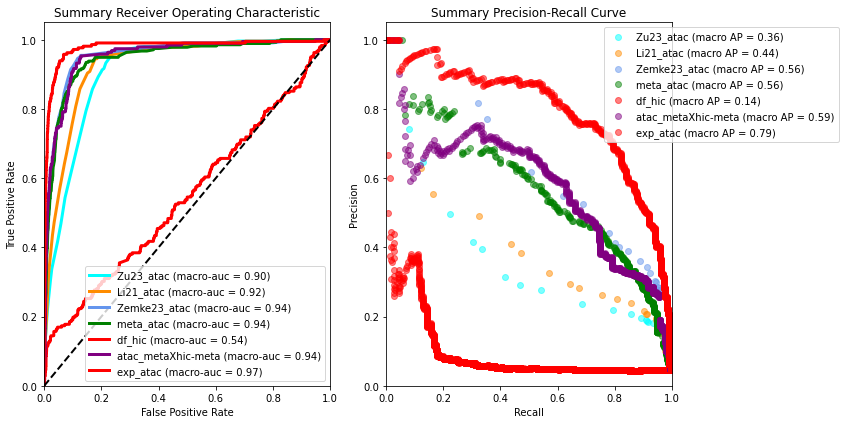

In [52]:
    score_names = []
    score_list = []
    score_true = []
    

    for test_input, test_name in zip([df_Zu2023_table, df_Li2021_table, df_Zemke2023_table, df_meta, df_hic], ['Zu23_atac', 'Li21_atac', 'Zemke23_atac', 'meta_atac', 'df_hic']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()       
        df_subset, df_test_input_z = preprocess_for_auc(df, df_test_input)                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)

        score_true.append(df_test_input_z.fillna(0).values)
        
    for test_input, test_name in zip([df_Zemke2023_table], ['atac_metaXhic-meta']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()
        zemke_x_raw_hic_downsteam_zscore= atac_x_hic_interaction(df_test_input, df_hic)           
        df_subset, df_test_input_z = preprocess_for_auc(df, zemke_x_raw_hic_downsteam_zscore )                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)
        score_true.append(df_test_input_z.fillna(0).values)
        
    for test_input, test_name in zip([exp_atac], ['exp_atac']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()        
        df_subset, df_test_input_z = preprocess_for_auc(df, df_test_input )                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)
        score_true.append(df_test_input_z.fillna(0).values)
        

    models_data = []
    for i, score in enumerate(score_names):


        dict1 = {}

        dict1['name'] = score_names[i]


        dict1['y_true'] =  score_list[i].T # We only use the on and mixed target enhancers
        dict1['y_score']=  score_true[i].T
        models_data.append(dict1)
        
    plot_summary_roc_aupr(models_data)

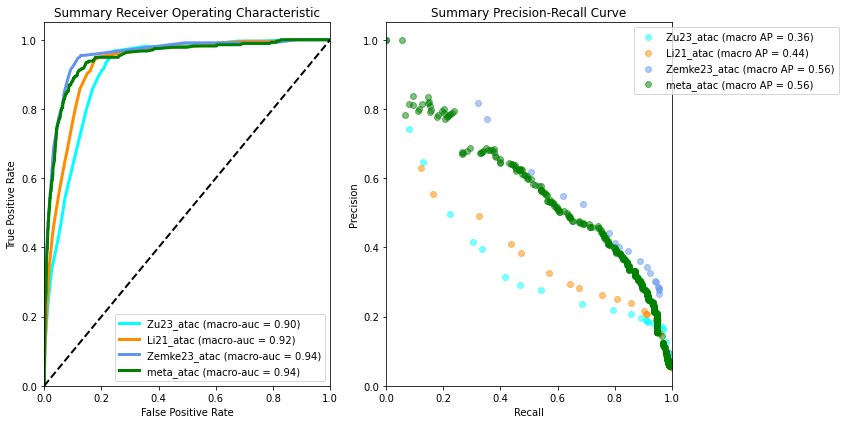

In [15]:
    score_names = []
    score_list = []
    score_true = []
    

    for test_input, test_name in zip([df_Zu2023_table, df_Li2021_table, df_Zemke2023_table, df_meta], ['Zu23_atac', 'Li21_atac', 'Zemke23_atac', 'meta_atac']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()       
        df_subset, df_test_input_z = preprocess_for_auc(df, df_test_input)                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)

        score_true.append(df_test_input_z.fillna(0).values)
        


    models_data = []
    for i, score in enumerate(score_names):


        dict1 = {}

        dict1['name'] = score_names[i]


        dict1['y_true'] =  score_list[i].T # We only use the on and mixed target enhancers
        dict1['y_score']=  score_true[i].T
        models_data.append(dict1)
        
    plot_summary_roc_aupr(models_data)

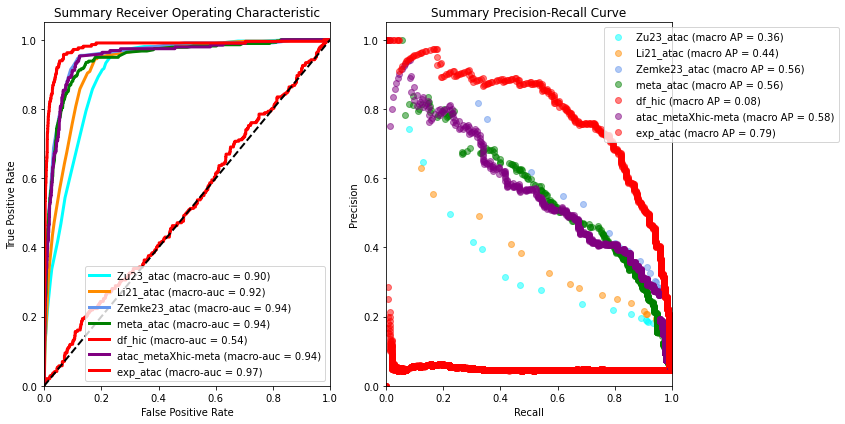

In [57]:
    score_names = []
    score_list = []
    score_true = []
    

    for test_input, test_name in zip([df_Zu2023_table, df_Li2021_table, df_Zemke2023_table, df_meta, df_hic], ['Zu23_atac', 'Li21_atac', 'Zemke23_atac', 'meta_atac', 'df_hic']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()       
        df_subset, df_test_input_z = preprocess_for_auc(df, df_test_input)                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)

        score_true.append(df_test_input_z.fillna(0).values)
        
    for test_input, test_name in zip([df_Zemke2023_table], ['atac_metaXhic-meta']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()
        zemke_x_raw_hic_downsteam_zscore= atac_x_hic_interaction(df_test_input, df_hic)           
        df_subset, df_test_input_z = preprocess_for_auc(df, zemke_x_raw_hic_downsteam_zscore )                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)
        score_true.append(df_test_input_z.fillna(0).values)
        
    for test_input, test_name in zip([exp_atac], ['exp_atac']):
        test_output = df_exp_all.copy()
        df_test_input = test_input.copy()
        df = test_output.copy()        
        df_subset, df_test_input_z = preprocess_for_auc(df, df_test_input )                      
        score_names.append(test_name)
        score_list.append(df_subset.fillna(0).values)
        score_true.append(df_test_input_z.fillna(0).values)
        

    models_data = []
    for i, score in enumerate(score_names):


        dict1 = {}

        dict1['name'] = score_names[i]


        dict1['y_true'] =  score_list[i].T # We only use the on and mixed target enhancers
        dict1['y_score']=  score_true[i].T
        models_data.append(dict1)
        
    plot_summary_roc_aupr(models_data)

In [62]:
df_Zu2023_table

enhancer_id            AiE0007m  AiE0019h  AiE0019m  AiE0025h  AiE0025m  \
cell_type                                                                 
Astro                       0.0       1.0       1.0       0.0       0.0   
Endo                        0.0       0.0       0.0       0.0       0.0   
L2/3 IT                     1.0       1.0       1.0       0.0       0.0   
L4/5 IT                     1.0       0.0       0.0       0.0       0.0   
L5 ET                       1.0       1.0       1.0       0.0       0.0   
L5 IT                       1.0       0.0       0.0       0.0       0.0   
L6 CT                       1.0       0.0       0.0       0.0       0.0   
L6 IT                       1.0       0.0       0.0       0.0       0.0   
L6b                         0.0       0.0       0.0       0.0       0.0   
Lamp5                       0.0       1.0       1.0       1.0       1.0   
Lamp5 Lhx6                  0.0       1.0       1.0       1.0       1.0   
Micro-PVM                   0.0       0.0       0.0       0.0       0.0   
OPC                         0.0       0.0       0.0       0.0       0.0   
Oligo                       0.0       0.0       0.0       0.0       0.0   
Peri                        0.0       0.0       0.0       0.0       0.0   
Pvalb                       0.0       1.0       1.0       0.0       0.0   
Pvalb chandelier Gaba       0.0       1.0       1.0       0.0       0.0   
SMC                         0.0       0.0       0.0       0.0       0.0   
Sncg                        1.0       1.0       1.0       0.0       0.0   
Sst                         1.0       1.0       1.0       0.0       0.0   
Sst Chodl                   1.0       1.0       1.0       0.0       0.0   
VLMC                        0.0       0.0       0.0       0.0       0.0   
Vip                         1.0       1.0       1.0       1.0       1.0   

enhancer_id            AiE0031m  AiE0049m  AiE0058h  AiE0058m  AiE0060m  ...  \
cell_type                                                                ...   
Astro                       1.0       0.0       0.0       0.0       1.0  ...   
Endo                        0.0       0.0       0.0       0.0       0.0  ...   
L2/3 IT                     1.0       1.0       1.0       1.0       0.0  ...   
L4/5 IT                     1.0       1.0       1.0       1.0       0.0  ...   
L5 ET                       0.0       0.0       0.0       0.0       0.0  ...   
L5 IT                       0.0       1.0       1.0       1.0       0.0  ...   
L6 CT                       0.0       0.0       0.0       0.0       0.0  ...   
L6 IT                       0.0       0.0       1.0       1.0       0.0  ...   
L6b                         0.0       1.0       0.0       0.0       0.0  ...   
Lamp5                       1.0       0.0       0.0       0.0       0.0  ...   
Lamp5 Lhx6                  0.0       0.0       0.0       0.0       0.0  ...   
Micro-PVM                   0.0       0.0       0.0       0.0       0.0  ...   
OPC                         1.0       0.0       0.0       0.0       1.0  ...   
Oligo                       1.0       0.0       0.0       0.0       0.0  ...   
Peri                        0.0       0.0       0.0       0.0       0.0  ...   
Pvalb                       1.0       1.0       0.0       0.0       1.0  ...   
Pvalb chandelier Gaba       0.0       0.0       0.0       0.0       1.0  ...   
SMC                         1.0       0.0       0.0       0.0       0.0  ...   
Sncg                        1.0       0.0       0.0       0.0       1.0  ...   
Sst                         1.0       0.0       0.0       0.0       1.0  ...   
Sst Chodl                   0.0       0.0       0.0       0.0       0.0  ...   
VLMC                        1.0       0.0       0.0       0.0       0.0  ...   
Vip                         1.0       0.0       0.0       0.0       1.0  ...   

enhancer_id            AiE2610m  AiE2612m  AiE2613m  AiE2615m  AiE2616m  \
cell_type                                       

In [61]:
#intra
score_auc = []
score_PR = []

for index_c in ['L2/3 IT', 'L5 IT', 'L6 IT', 'L6 CT', 'L6b', 'Lamp5', 'Sncg', 'Vip',
       'Sst Chodl', 'Sst', 'Pvalb', 'Astro', 'Oligo', 'VLMC', 'Endo']:
    score_names = []
    score_list = []
    score_true = []
    

    for test_input, test_name in zip([df_Zu2023_table, df_Li2021_table, df_Zemke2023_mouse, df_meta], ['Zu23_atac', 'Li21_atac', 'Zemke23_atac', 'meta_atac']):
        test_output = df_exp_all.copy()
        df_Zemke2023_table = test_input[test_input.index.isin(class_intersect)].copy()
        #df_Zemke2023_table = test_input.copy()
        df = test_output.copy()
        #zemke_x_raw_hic_downsteam_zscore= atacXhic(df_Zemke2023_table, df)           
        df_subset, df_Zemke2023_table_z = pre_auc(df, df_Zemke2023_table )                      
        score_names.append(test_name)
        score_list.append(df_subset.loc[index_c ,:].fillna(0).values)
        print (df_subset.index)
        score_true.append(df_Zemke2023_table_z.loc[index_c ,:].fillna(0).values)
        
    for test_input, test_name in zip([ df_meta], ['atac_metaXhic-meta']):
        test_output = df_exp_all.copy()
        df_Zemke2023_table = test_input[test_input.index.isin(class_intersect)].copy()
        #df_Zemke2023_table = test_input.copy()
        df = test_output.copy()
        zemke_x_raw_hic_downsteam_zscore= atacXhic(df_Zemke2023_table, dk_input)           
        df_subset, df_Zemke2023_table_z = pre_auc(df, zemke_x_raw_hic_downsteam_zscore )                      
        score_names.append(test_name)
        score_list.append(df_subset.loc[index_c ,:].fillna(0).values)
        score_true.append(df_Zemke2023_table_z.loc[index_c ,:].fillna(0).values)
        
    for test_input, test_name in zip([exp_atac], ['exp_atac']):
        test_output = df_exp_all.copy()
        df_Zemke2023_table = test_input[test_input.index.isin(class_intersect)].copy()
        #df_Zemke2023_table = test_input.copy()
        df = test_output.copy()
        #zemke_x_raw_hic_downsteam_zscore= atacXhic(df_Zemke2023_table, df)           
        df_subset, df_Zemke2023_table_z = pre_auc(df, df_Zemke2023_table )                      
        score_names.append(test_name)
        score_list.append(df_subset.loc[index_c ,:].fillna(0).values)
        print (df_subset.index)
        score_true.append(df_Zemke2023_table_z.loc[index_c ,:].fillna(0).values)

    models_data = []
    for i, score in enumerate(score_names):




        dict1 = {}
        print (index_c)
        
        dict1['name'] = score_names[i]
        print (score_names[i])

        dict1['y_true'] =  score_list[i].T # We only use the on and mixed target enhancers
        dict1['y_score']=  score_true[i].T
        fpr, tpr, _ = roc_curve(dict1['y_true'], dict1['y_score'])

        roc_auc_micro = auc(fpr, tpr)
        score_auc.append(roc_auc_micro)
        
        score_PR.append(average_precision_score(dict1['y_true'], dict1['y_score']))


        models_data.append(dict1)
        
        

    plot_summary_roc_aupr(models_data)

[{'name': 'Zu23_atac',
  'y_true': array([[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'y_score': array([[-0.79772404, -0.79772404,  1.25356634, ..., -0.79772404,
           1.25356634, -0.79772404],
         [-0.79772404, -0.79772404,  1.25356634, ..., -0.79772404,
          -0.79772404, -0.79772404],
         [-1.        , -1.        ,  1.        , ..., -1.        ,
           1.        , -1.        ],
         ...,
         [ 4.12310563, -0.24253563, -0.24253563, ..., -0.24253563,
          -0.24253563, -0.24253563],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [-0.62017367, -0.62017367,  1.61245155, ..., -0.62017367,
          -0.62017367, -0.62017367]])},
 {'name': 'Li21_atac',
  'y_true': array([[0., 0., 0., ...,

In [60]:
num_rows = len(score_auc) // len(score_names)
score_auc_2d = np.array(score_auc[:num_rows*len(score_names)]).reshape(num_rows, len(score_names))
df = pd.DataFrame(data=score_auc_2d, columns=score_names)



df.index = ['L2/3 IT', 'L5 IT', 'L6 IT', 'L6 CT', 'L6b', 'Lamp5', 'Sncg', 'Vip',
       'Sst Chodl', 'Sst', 'Pvalb', 'Astro', 'Oligo', 'VLMC', 'Endo',]

NameError: name 'score_auc' is not defined